<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/ArchitectureGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Using 1 GPU


Epoch 0: Loss 0.5783784493240526
Epoch 10: Loss 0.5516056054418667
Epoch 20: Loss 0.5220887106536422
Epoch 30: Loss 0.4907133398922835
Epoch 40: Loss 0.45430099829296594
Epoch 50: Loss 0.4176372366261089
Epoch 60: Loss 0.3782068507971352
Epoch 70: Loss 0.33605745013459865
Epoch 80: Loss 0.29504612217912335
Epoch 90: Loss 0.25158533668532385
Epoch 100: Loss 0.21131816186874514
Epoch 110: Loss 0.17491390147975588
Epoch 120: Loss 0.14141243402176398
Epoch 130: Loss 0.10790058988942781
Epoch 140: Loss 0.08769814711949837
Epoch 150: Loss 0.06772822589436024
Epoch 160: Loss 0.051915476977608815
Epoch 170: Loss 0.03717998583935324
Epoch 180: Loss 0.027666572615352544
Epoch 190: Loss 0.024062053715349863
Epoch 200: Loss 0.016914657145431444
Epoch 210: Loss 0.010999396009982202
Epoch 220: Loss 0.00822610420247976
Epoch 230: Loss 0.005825062535416309
Epoch 240: Loss 0.004566225663747829
Epoch 250: Loss 0.0044651915194078105
Epoch 260: Loss 0.004749454725813667
Epoch 270: Loss 0.00306477484189038

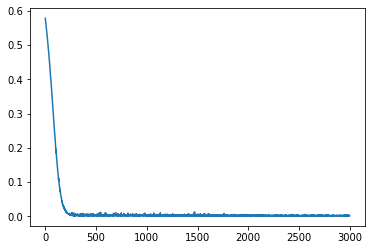

In [6]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from modules import regenerate_PWMatrix
from scipy.stats import wasserstein_distance as WD

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []
typed_trimmed_specs = List()

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
        typed_trimmed_specs.append(specs[i])

@njit()
def get_LT(full_ar):
    ar = []
    for i in range(len(full_ar)):
        for j in range(i):
            ar.append(full_ar[i][j])
    return ar

@njit()
def generate_matrix(comm):
    dim = len(comm)
    ar = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                ar[i][j] = 0
            else:
                r = rd.random()
                ar[i][j] = r
                ar[j][i] = 1-r

    return ar

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
    print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self, hyperparam):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, hyperparam)
        self.fc2 = nn.Linear(hyperparam, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def test_net(model, Lambda_Mat):
    full_cm = predict_community_fullnp(Lambda_Mat, trimmed_specs)
    input = torch.from_numpy(full_cm).float().to(device)
    Lambda_Mat_pred = model(input).to(device)

    true_y = torch.FloatTensor(np.array(get_LT(Lambda_Mat))).to(device)

    loss1 = criterion(Lambda_Mat_pred, true_y).to(device)
    s = sqrt(loss1.item()/(231*461))
    LMP_list = Lambda_Mat_pred.tolist()
    lam2 = np.array(regenerate_PWMatrix(LMP_list, 462))
    cm_pred = predict_community_fullnp(lam2, trimmed_specs)
    loss2 = WD(full_cm, cm_pred)
    print(s)
    print(loss2)
    print([x.round(4) for x in full_cm])
    print([x.round(4) for x in cm_pred])

def train_net(model, train_size):
    full_m = pd.DataFrame(generate_matrix(typed_trimmed_specs), index=trimmed_specs, columns=trimmed_specs)
    train_y = get_LT(full_m.to_numpy())
    loss_values = []
    pbar2=tqdm(range(train_size))
    pbar2.set_description('Training Neural Net')
    for epoch in pbar2:

        npcm = np.zeros(len(trimmed_specs))
        size = rd.randint(25, 235)
        subset = rd.sample(trimmed_specs, size)
        subset_lam = (full_m.loc[subset, subset]).to_numpy()
        cm = predict_community_fullnp(subset_lam, subset, verb=False)

        for i in range(len(cm)):
            npcm[trimmed_specs.index(subset[i])] = cm[i]

        
        optimizer.zero_grad()

        x, y = npcm, train_y

        input = torch.from_numpy(x).float().to(device)
        true_y = torch.FloatTensor(y).to(device)
        output = model(input).to(device)
        loss = criterion(output, true_y).to(device)
        s = sqrt(loss.item()/(231*461))
        if (epoch % 10)==0:
          print(f'Epoch {epoch}: Loss {s}')
        loss_values.append(s)
        loss.backward()
        optimizer.step()

    return loss_values, train_y

if __name__=='__main__':
    train_size, test_size, param = 3000, 25, 2500
    path = 'model.pth'

    net = MyNet(param).to(device)

    #Multi GPU Support
    if torch.cuda.device_count() > 1:
          print(f'Using {torch.cuda.device_count()} GPUs')
          net = nn.DataParallel(net)
    elif torch.cuda.device_count() == 1:
        print(f'Using {torch.cuda.device_count()} GPU')

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    lv, full_lam = train_net(net, train_size=train_size)
    full_lam = np.array(regenerate_PWMatrix(full_lam, 462))
    test_net(net, full_lam)
    torch.save(net.state_dict(), path)
    plt.plot(lv)
    plt.savefig('Loss')
    plt.show()
